# Movie Genre Classification

## For this task, we'll be using Logistic Regression and Naive Bayes Classifier to classify the Genre of a movie based on the description

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Lets read the Train Dataset

In [2]:
df_train = pd.read_csv("../Genre Classification Dataset/train_data.txt",
                 sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
df_train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
df_train.describe().T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [5]:
df_train.shape

(54214, 3)

In [6]:
df_train.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

##### From the above we can clearly see that the dataset contains no null values. There are 54214 rows and 3 columns, and all the columns are of object data type.

### Lets read the Test dataset

In [8]:
df_test = pd.read_csv(r"..\Genre Classification Dataset\test_data.txt",
                  sep=':::',names=['Title', 'Description']).reset_index(drop=True)
df_test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


In [9]:
df_test.isnull().sum()

Title          0
Description    0
dtype: int64

In [10]:
df_test.describe()

,Title,Description
count,54200,54200
unique,54200,54072
top,Edgar's Lunch (1998),Grammy - music award of the American academy ...
freq,1,10


In [11]:
df_test.shape

(54200, 2)

### Data Cleaning - Train Data & Test Data

In [12]:
#importing Regex library
import re

#importing String library for finding digits, punctuations etc in our text
import string

In [13]:
def data_clean(txt):
    # Removing punctuations
    txt = re.sub(f'[{string.punctuation}]','',txt)
    
    # Removing numbers
    txt = re.sub(f'[{string.digits}]','',txt)
    
    # Removing single characters 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)
    
    # Removing emails
    txt = re.sub(r'@\S+', '', txt)
    
    # Removing URLs
    txt = re.sub(r'http\S+', '', txt)
    
    return txt

In [14]:
# Applying the Data Cleaning function to the Description column of Train and Test Dataset 
df_train['Description'] = df_train['Description'].apply(data_clean)
df_test['Description'] = df_test['Description'].apply(data_clean)

In [15]:
df_train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to conversation between his doct...
1,Cupid (1997),thriller,brother and sister with past incestuous relat...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The films title refers not only to the unreco...


In [16]:
df_test.head()

,Title,Description
0,Edgar's Lunch (1998),LR Brane loves his life his car his apartmen...
1,La guerra de papá (1977),Spain March Quico is very naughty child of t...
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),His father has died he hasnt spoken with his ...
4,Er nu zhai (1955),Before he was known internationally as martia...


##### Now we can see that the punctuation, digits etc were removed from the description column of the train and test dataset

### Lets check the distribution of genre in our dataset

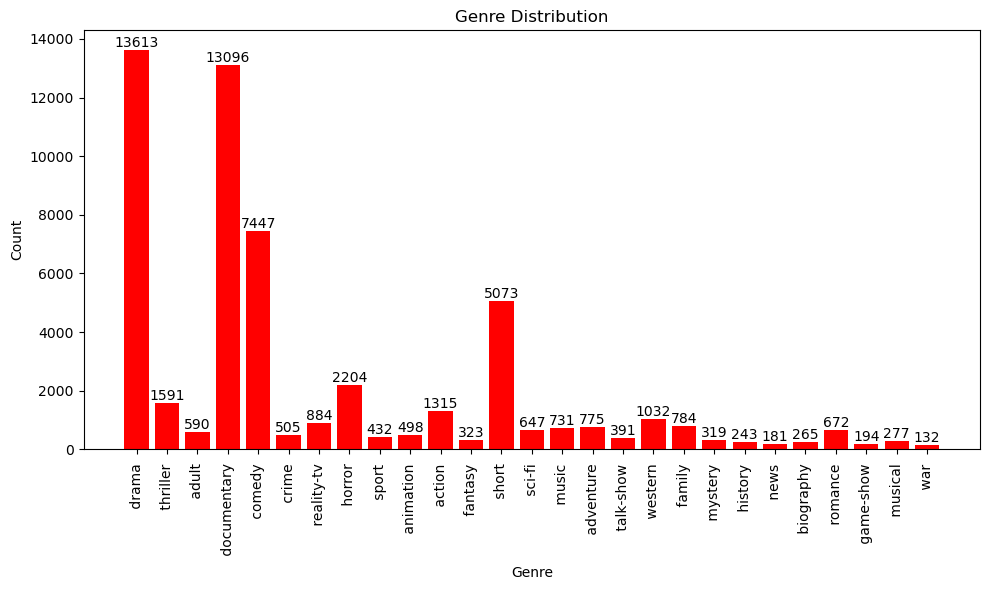

In [17]:
from collections import Counter

# Count the occurrences of each genre
genre_counts = Counter(df_train['Genre'])

# Prepare data for plotting
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(genres, counts, color='red')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Add count values above the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### From the above we can clearly see that the data is imblanced as the drama and documentary genres are high in numbers and other genres are very low. This will affect the accuracy of our model.

### Model Building

In [18]:
# importing required Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

In [19]:
# Now, We have to vectorize the Description column. For that,
tfidf = TfidfVectorizer(lowercase=True, # convert text to lowercase
                                   stop_words='english',# Remove stop_words
                                   min_df=1) # Minimum frequency required for a term to be included in the vocabulary.

In [20]:
X_train = tfidf.fit_transform(df_train['Description'])
X_test = tfidf.transform(df_test['Description'])

In [21]:
y_train = df_train['Genre']
print(y_train)

0               drama 
1            thriller 
2               adult 
3               drama 
4               drama 
             ...      
54209          comedy 
54210          horror 
54211     documentary 
54212          comedy 
54213         history 
Name: Genre, Length: 54214, dtype: object


In [23]:
#Get the actual solutions from test_data_solution.txt to compare it with our predictions
y_test_solution = pd.read_csv(r"..\Genre Classification Dataset\test_data_solution.txt",
                      sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_test = y_test_solution['Actual_Genre']
print(y_test)

0            thriller 
1              comedy 
2         documentary 
3               drama 
4               drama 
             ...      
54195          horror 
54196         western 
54197           adult 
54198           drama 
54199           drama 
Name: Actual_Genre, Length: 54200, dtype: object


In [29]:
nb_model = MultinomialNB(alpha=0.1)
lr_model = LogisticRegression()

### Naive Bayes Model:

In [30]:
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [31]:
nb_model_prediction = nb_model.predict(X_test)

In [32]:
nb_model_accuracy = accuracy_score(y_test, nb_model_prediction) * 100 
nb_model_accuracy = round(nb_model_accuracy, 2)

print('Accuracy score of ', nb_model, 'model = ', nb_model_accuracy,'%')
print('----------------------------------------------------------------')

Accuracy score of  MultinomialNB(alpha=0.1) model =  50.56 %
----------------------------------------------------------------


### Logistic Regression Model:

In [33]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [34]:
lr_model_prediction = lr_model.predict(X_test)

In [35]:
lr_model_accuracy = accuracy_score(y_test, lr_model_prediction) * 100 
lr_model_accuracy = round(lr_model_accuracy, 2)

print('Accuracy score of ', lr_model, 'model = ', lr_model_accuracy,'%')
print('----------------------------------------------------------------')

Accuracy score of  LogisticRegression() model =  58.57 %
----------------------------------------------------------------


#### From the above we can clearly see that the Logistic Regression model has higher accuracy than the Naive Bayes model

### Making a Predictive system

In [39]:
movie_description= input("Enter the description here! \n\n")
      
if(movie_description == ''):
    print('Invalid Input')
else:
    # Cleaning the Input
    cleaned_description = data_clean(movie_description)
    print('\n Cleaned Input :')
    print('\n',cleaned_description,'\n')
    
    # Vectorize the input
    movie_description_vectorized = tfidf.transform([cleaned_description]).reshape(1,-1)

    # Prediction of Naive Bayes Model:
    nb_model_prediction_system = nb_model.predict(movie_description_vectorized)
    print('Prediction of Naive Bayes Model :',nb_model_prediction_system[0].title())
    print('......................................................\n')

    # Prediction of Logistic Regression Model:
    lr_model_prediction_system = lr_model.predict(movie_description_vectorized)
    print('Prediction of Logistic Regression Model :',lr_model_prediction_system[0].title())
    print('......................................................')

Enter the description here! 

  L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.



 Cleaned Input :

  LR Brane loves his life  his car his apartment his job but especially his girlfriend Vespa One day while showering Vespa runs out of shampoo LR runs across the street to convenience store to buy some more quick trip of no more than few minutes When he returns Vespa is gone and every trace of her existence has been wiped out LRs life becomes tortured existence as one strange event after another occurs to confirm in his mind that conspiracy is working against his finding Vespa 

Prediction of Naive Bayes Model :  Comedy 
......................................................

Prediction of Logistic Regression Model :  Drama 
......................................................


### Now we will move on to the Deployment part

In [40]:
import pickle

In [47]:
filename = 'movie_genre_classification_model.sav'
pickle.dump(models, open(filename, 'wb'))

In [43]:
# loading the saved model
loaded_model = pickle.load(open('movie_genre_classification_model.sav', 'rb'))

In [44]:
print(loaded_model)

[MultinomialNB(alpha=0.1), LogisticRegression()]


In [46]:
movie_desc= """L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa."""
      
# if(movie_desc == ''):
#     print('Invalid Input')
# else:

# Cleaning the Input
cleaned_desc = data_clean(movie_desc)
# print('\n Cleaned Input :')
# print('\n',cleaned_desc,'\n')
    
# Vectorize the input
movie_desc_vectorized = tfidf.transform([cleaned_desc]).reshape(1,-1)
    
# Prediction of Naive Bayes Model:
nb_model_pred = loaded_model[0].predict(movie_desc_vectorized)
print('Prediction of Naive Bayes Model :',nb_model_pred[0].title())
print('......................................................\n')

# Prediction of Logistic Regression Model:
lr_model_pred = loaded_model[1].predict(movie_desc_vectorized)
print('Prediction of Logistic Regression Model :',lr_model_pred[0].title())
print('......................................................')

Prediction of Naive Bayes Model :  Comedy 
......................................................

Prediction of Logistic Regression Model :  Drama 
......................................................


### Thus we have successfully saved our model as .sav file and the model is working correctly